In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Camera calibration and Undistort

## Camera Calibration

In [3]:
def camera_calibration(images, nx, ny):
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    img_size = (1280, 720)
    
    for frame in images:
        img = cv2.imread(frame)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

## Undistort

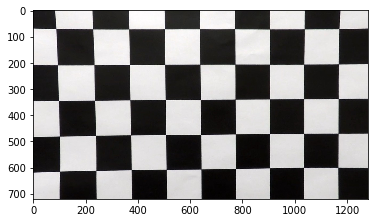

In [4]:
img = mpimg.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

# Perspective Transform

In [5]:
def corners_unwarp(undist, nx, ny, mtx, dist):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
        dst = np.float32([[100, 100], [1150,100], [1150, 650], [100, 650]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
        
    return warped, M

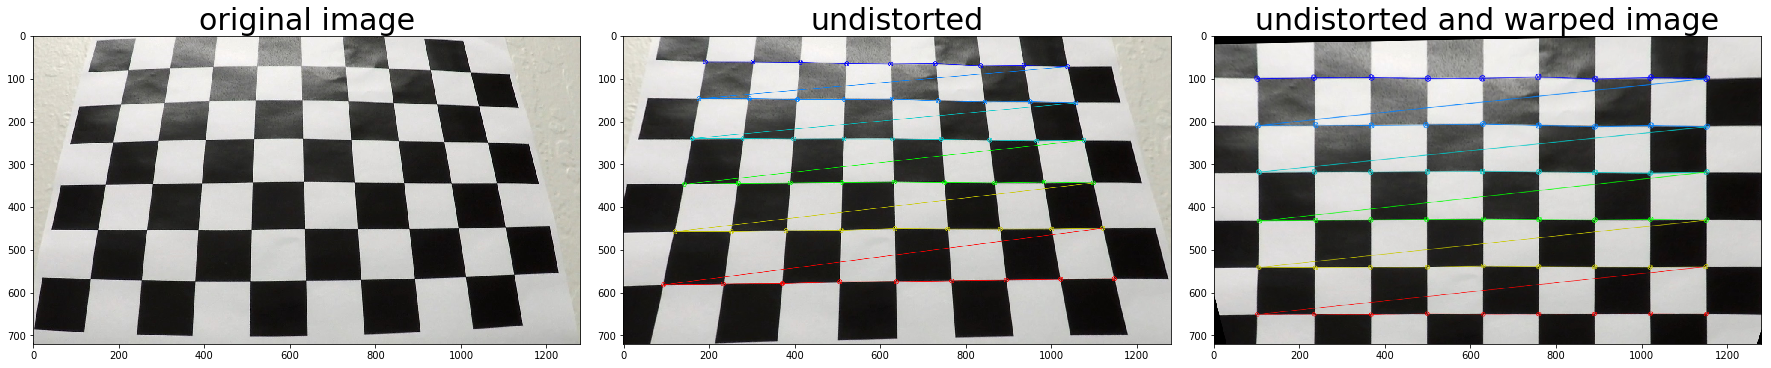

In [6]:
img = mpimg.imread("camera_cal/calibration3.jpg")
nx = 9
ny = 6
undist = cv2.undistort(img, mtx, dist, None, mtx)

top_down, perspective_M = corners_unwarp(undist, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(top_down)
ax3.set_title('undistorted and warped image', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

# Sobel

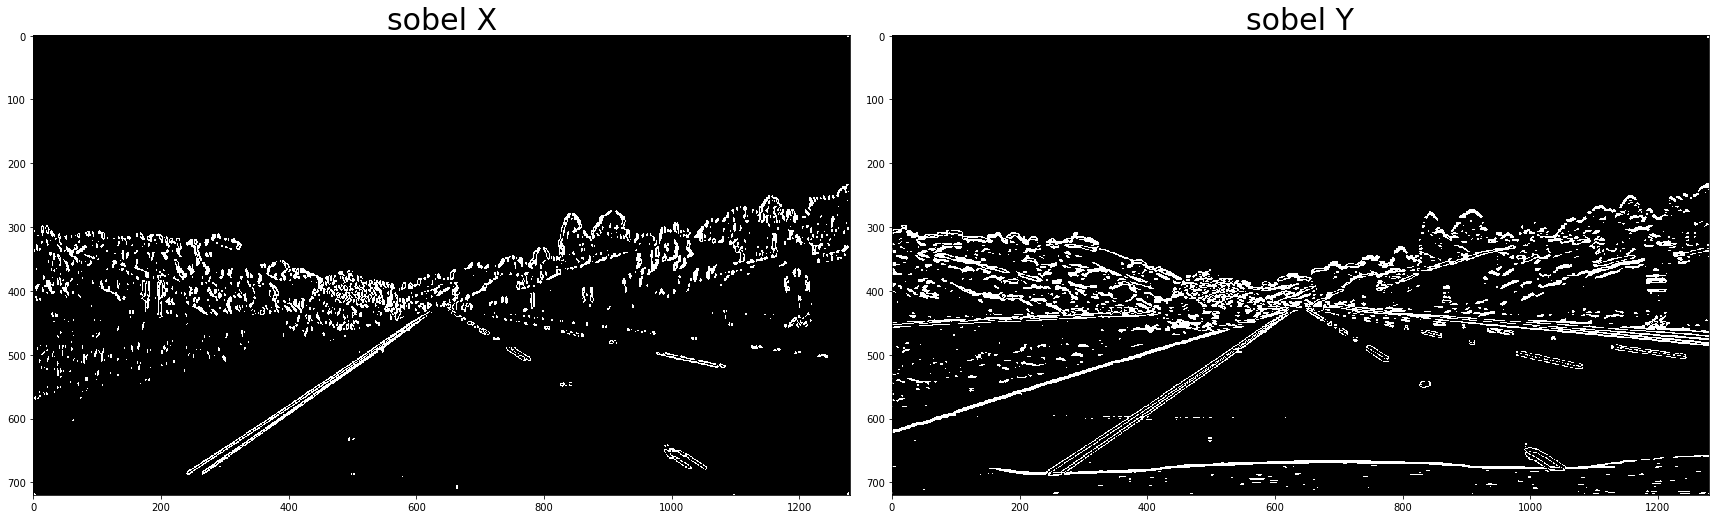

In [7]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    if (orient=='x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
sxbinary = abs_sobel_thresh(blur, 'x', 9, (30, 100))
sybinary = abs_sobel_thresh(blur, 'y', 9, (30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sxbinary, cmap='gray')
ax1.set_title('sobel X', fontsize=30)
ax2.imshow(sybinary, cmap='gray')
ax2.set_title('sobel Y', fontsize=30)

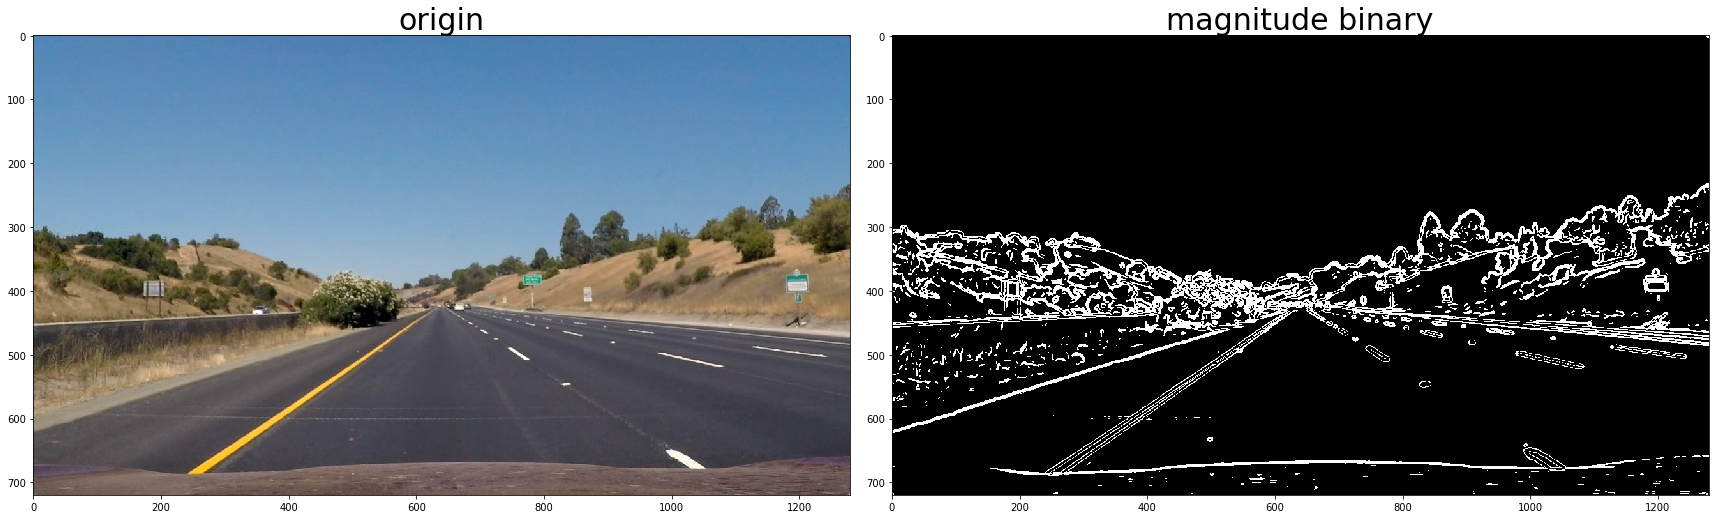

In [8]:
def mag_thresh(img, sobel_kernel, thresh):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary
    
img = mpimg.imread("test_images/s1.jpg")   
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
mag_binary = mag_thresh(blur, 9, (30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('magnitude binary', fontsize=30)
    

# Direction

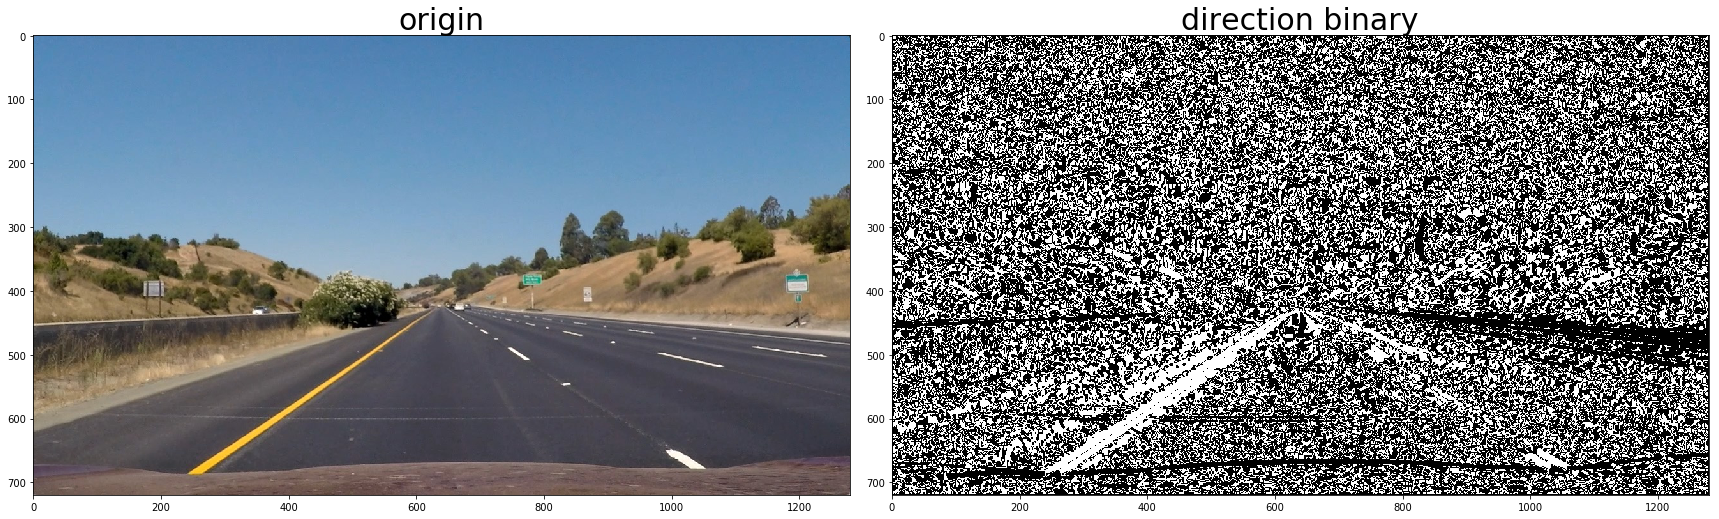

In [9]:
def dir_thresh(img, sobel_kernel, thresh):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     scaled_gradir = np.uint8(np.pi * gradir / 2 * np.max(gradir)) 
#     why not normalized?
    binary = np.zeros_like(gradir)
    binary[(gradir >= thresh[0]) & (gradir <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0) 
dir_binary = dir_thresh(blur, 15, (0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('direction binary', fontsize=30)

# Combine Thresholds
Now consider how to use various aspects of your gradient measurements(x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use **thresholds of the x and y gradients** or **the overall gradient magnitude and direction** to focus on pixels that are likely to be part of the lane lines.

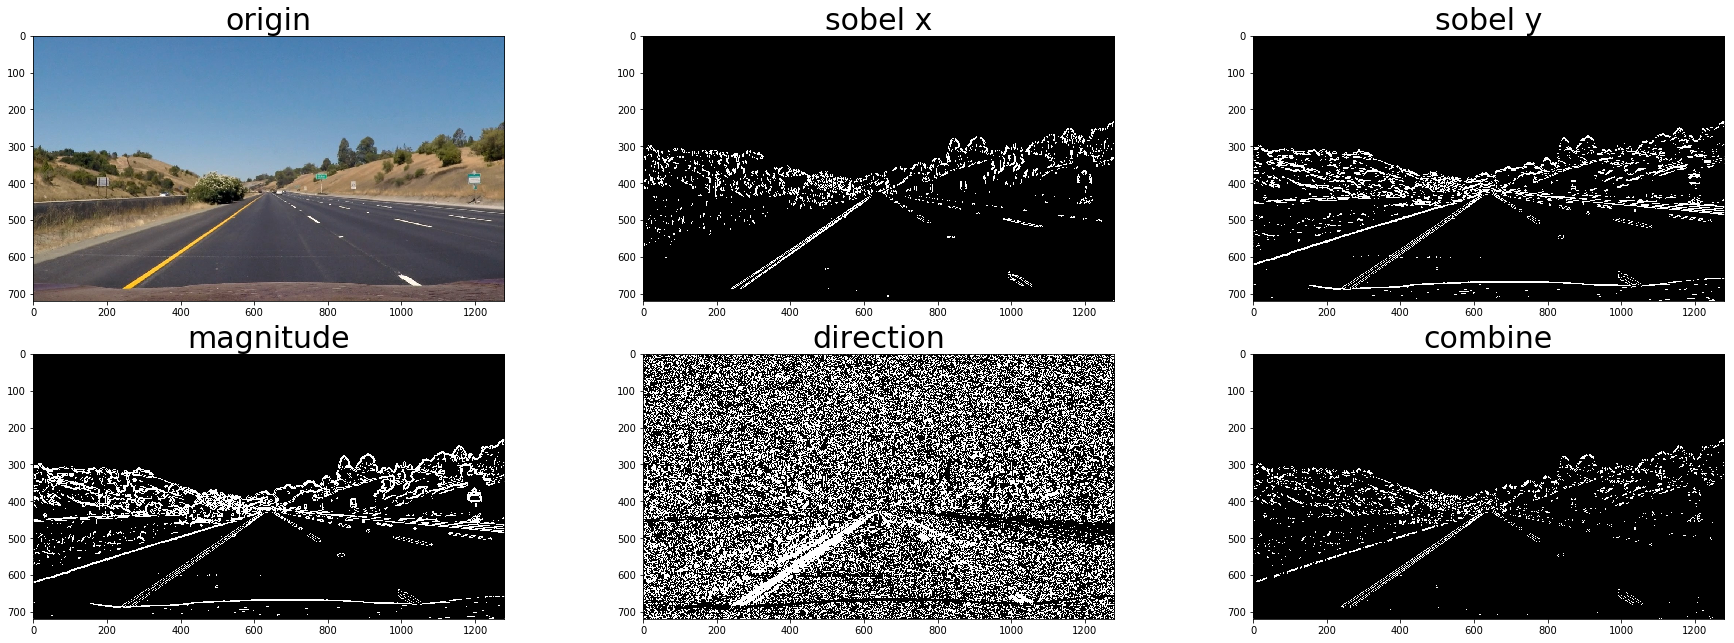

In [10]:
img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0) 

sx_binary = abs_sobel_thresh(blur, 'x', 9, (30, 100))
sy_binary = abs_sobel_thresh(blur, 'y', 9, (30, 100))
mag_binary = mag_thresh(blur, 9, (30, 100))
dir_binary = dir_thresh(blur, 15, (0.7, 1.3))
combined = np.zeros_like(dir_binary)
# threshold of x,y gradient or magnitude and direction
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0, 0].imshow(img), axs[0, 0].set_title('origin', fontsize=30)
axs[0, 1].imshow(sx_binary, cmap='gray') ,axs[0, 1].set_title('sobel x', fontsize=30)
axs[0, 2].imshow(sy_binary, cmap='gray'), axs[0, 2].set_title('sobel y', fontsize=30)
axs[1, 0].imshow(mag_binary, cmap='gray'), axs[1, 0].set_title('magnitude', fontsize=30)
axs[1, 1].imshow(dir_binary, cmap='gray'), axs[1, 1].set_title('direction', fontsize=30)
axs[1, 2].imshow(combined, cmap='gray'), axs[1, 2].set_title('combine', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

# Color Space (HLS)

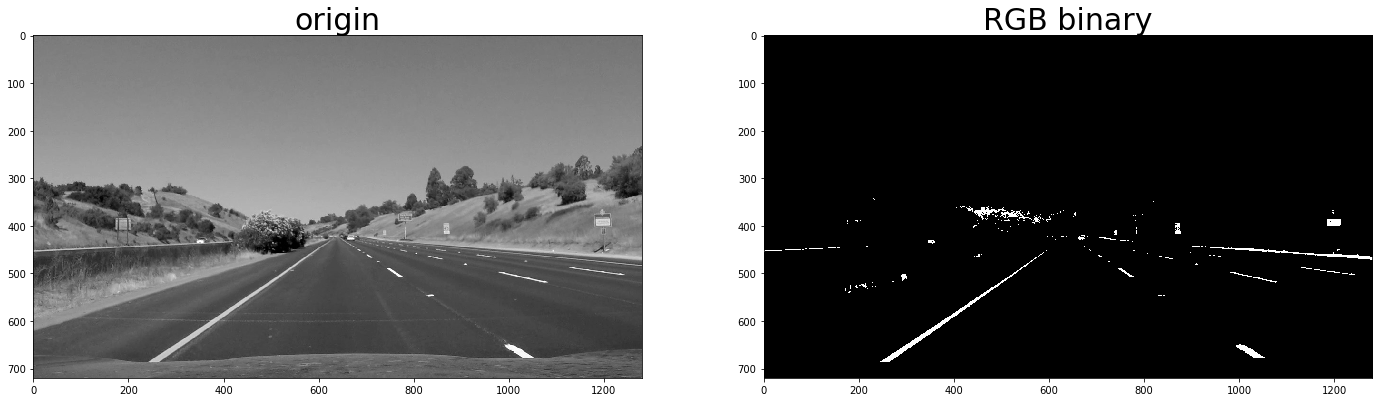

In [11]:
img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > 180) & (gray < 255)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(gray, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('RGB binary', fontsize=30)

## RGB

In [12]:
def rgb_thresh(img, channel, thresh):
    channel = img[:,:,channel]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel < thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")
R = hls[:,:,0]
G = hls[:,:,1]
B = hls[:,:,2]
r_binary = rgb_thresh(img, 0, (150, 255))
g_binary = rgb_thresh(img, 1, (150, 255))
b_binary = rgb_thresh(img, 2, (150, 255))

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0, 0].imshow(R, cmap='gray') ,axs[0, 0].set_title('R', fontsize=30)
axs[0, 1].imshow(G, cmap='gray'), axs[0, 1].set_title('G', fontsize=30)
axs[0, 2].imshow(B, cmap='gray'), axs[0, 2].set_title('B', fontsize=30)
axs[1, 0].imshow(r_binary, cmap='gray') ,axs[1, 0].set_title('R binary', fontsize=30)
axs[1, 1].imshow(g_binary, cmap='gray'), axs[1, 1].set_title('G binary', fontsize=30)
axs[1, 2].imshow(b_binary, cmap='gray'), axs[1, 2].set_title('B binary', fontsize=30)

NameError: name 'hls' is not defined

## HLS

(<matplotlib.image.AxesImage at 0x7f99841f79e8>,
 <matplotlib.text.Text at 0x7f9984244e48>)

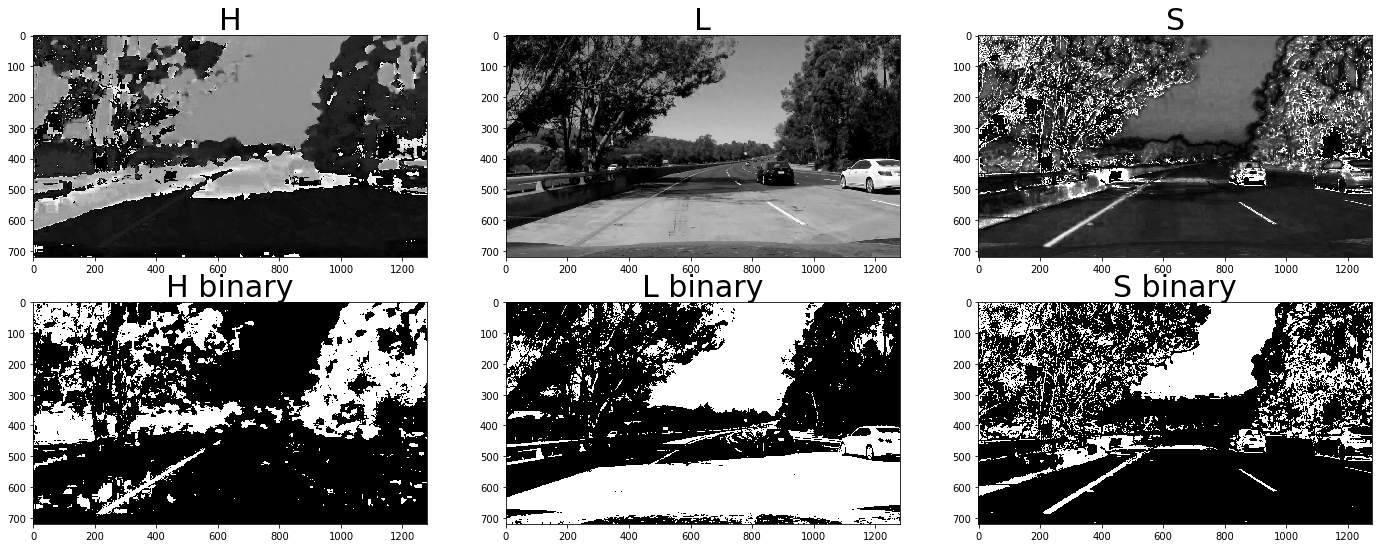

In [16]:
def hls_thresh(img, channel_number, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel_number]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/c5.jpg")
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
H_binary = hls_thresh(img, 0, (15, 100))
L_binary = hls_thresh(img, 1, (90, 255))
S_binary = hls_thresh(img, 2, (90, 255))

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0, 0].imshow(H, cmap='gray') ,axs[0, 0].set_title('H', fontsize=30)
axs[0, 1].imshow(L, cmap='gray'), axs[0, 1].set_title('L', fontsize=30)
axs[0, 2].imshow(S, cmap='gray'), axs[0, 2].set_title('S', fontsize=30)
axs[1, 0].imshow(H_binary, cmap='gray') ,axs[1, 0].set_title('H binary', fontsize=30)
axs[1, 1].imshow(L_binary, cmap='gray'), axs[1, 1].set_title('L binary', fontsize=30)
axs[1, 2].imshow(S_binary, cmap='gray'), axs[1, 2].set_title('S binary', fontsize=30)

# Combine thresh

(<matplotlib.image.AxesImage at 0x7f99840d7208>,
 <matplotlib.text.Text at 0x7f9984133eb8>)

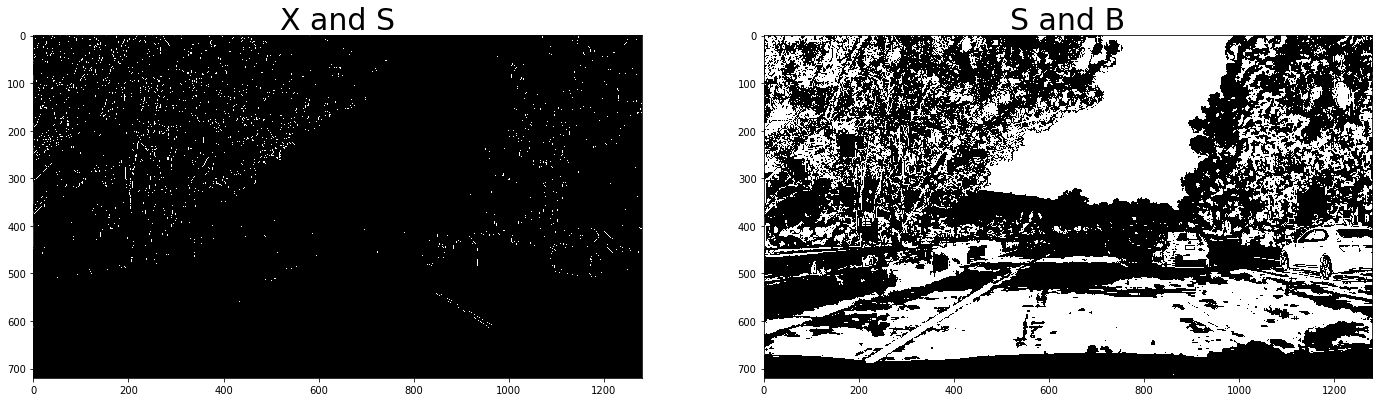

In [17]:
# combine sobel x and saturatioin
def xs_thresh(img, x_thresh, s_thresh):
    # img shound be undistorted
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0) 
    sxbinary = abs_sobel_thresh(blur, 'x', 3, x_thresh)
    s_binary = hls_thresh(img, 2, s_thresh)

    # stack each channel to view theri individual contributions in green and blue respectively
    # this returns a stack of the two binary images, whose components you can see as different colors
#     color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    xs_binary = np.zeros_like(sxbinary)
    xs_binary[(sxbinary == 1) & (s_binary == 1)] = 1

    return xs_binary

# combine saturation or blue
def sb_thresh(img, s_thresh, b_thresh):    
    s_binary = hls_thresh(img, 2, s_thresh)
    b_binary = rgb_thresh(img, 2, b_thresh)
    sb_binary = np.zeros_like(sxbinary)
    sb_binary[(b_binary == 1) | (s_binary == 1)] = 1
    return sb_binary

img = mpimg.imread("test_images/c5.jpg")
xs_binary = xs_thresh(img, (20, 100), (170, 255))
sb_binary = sb_thresh(img, (100, 255), (150, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(xs_binary, cmap='gray'), ax1.set_title('X and S', fontsize=30)
ax2.imshow(sb_binary, cmap='gray'), ax2.set_title('S and B', fontsize=30)

# Binary

(<matplotlib.image.AxesImage at 0x7f9976faf6a0>,
 <matplotlib.text.Text at 0x7f9976f89d30>)

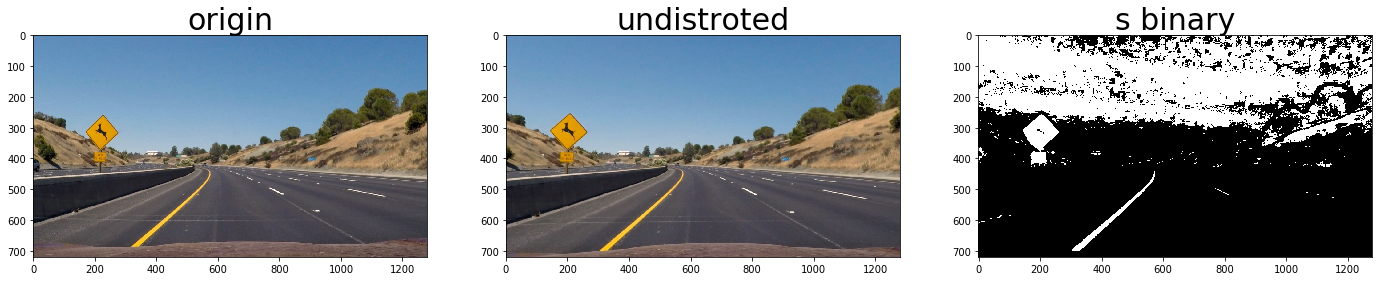

In [18]:
img = mpimg.imread("test_images/c2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
s_binary = hls_thresh(undist, 2, (100, 255))

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('origin', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistroted', fontsize=30)
axs[2].imshow(s_binary, cmap='gray'), axs[2].set_title('s binary', fontsize=30)

# ROI

(<matplotlib.image.AxesImage at 0x7f998c954240>,
 <matplotlib.text.Text at 0x7f9984189d68>)

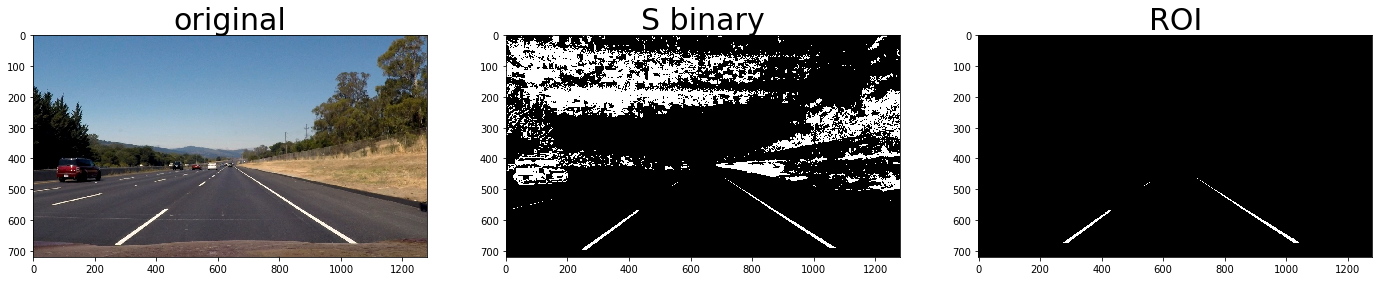

In [19]:
left_bottom = (200, 672)
left_top = (560, 460)
right_bottom = (1160, 672)
right_top = (740, 460)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]

def region_of_interest(img, roi_points):
    mask = np.zeros_like(img)
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread("test_images/s2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
s_binary = hls_thresh(undist, 2, (100, 255))
roi = region_of_interest(s_binary, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(s_binary, cmap='gray'), axs[1].set_title('S binary', fontsize=30)
axs[2].imshow(roi, cmap='gray'), axs[2].set_title('ROI', fontsize=30)

# Warp

(<matplotlib.image.AxesImage at 0x7f998c91b3c8>,
 <matplotlib.text.Text at 0x7f998c9e2c88>)

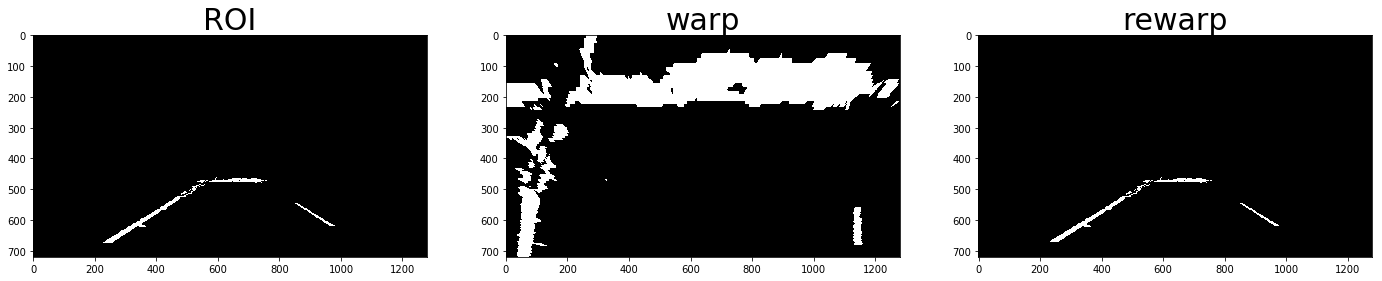

In [20]:
def warp(img, roi_points):
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)    
    return warped

def rewarp(img, roi_points):
    dst = np.float32(roi_points)
    src = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    rewarped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    return rewarped
    
img = mpimg.imread("test_images/c5.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
s_binary = hls_thresh(undist, 2, (100, 255))
roi = region_of_interest(s_binary, roi_points)
warped = warp(roi, roi_points)
rewarped = rewarp(warped, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(rewarped, cmap='gray'), axs[2].set_title('rewarp', fontsize=30)

# Histogram

([<matplotlib.lines.Line2D at 0x7f9976d2a9e8>],
 <matplotlib.text.Text at 0x7f9976d04a20>)

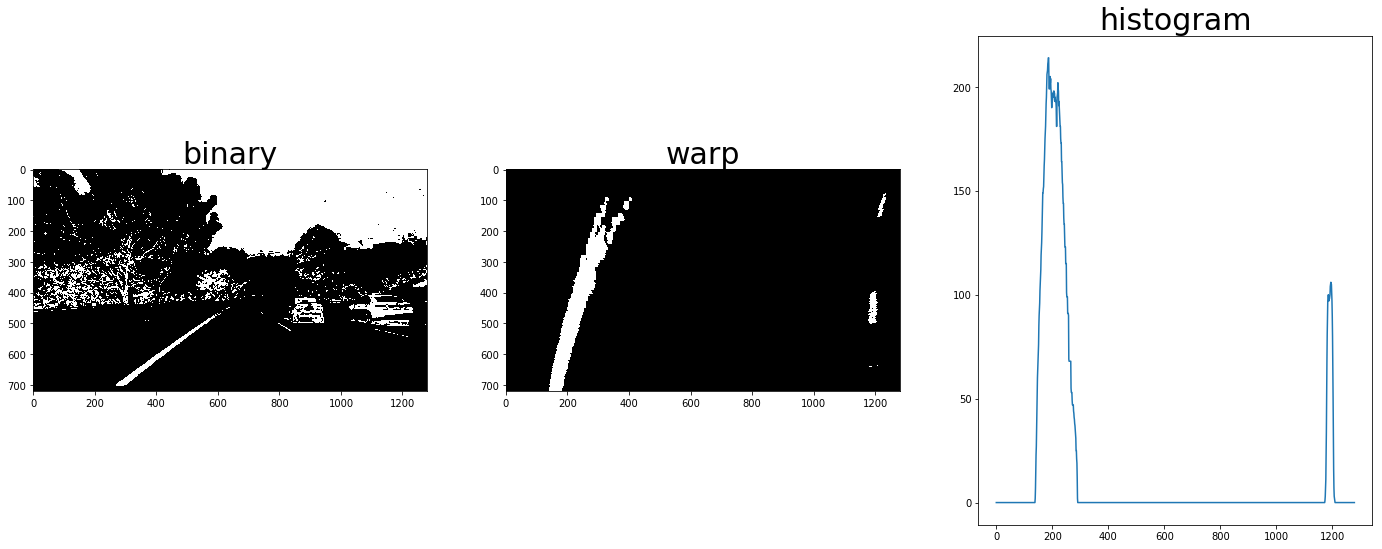

In [22]:
img = mpimg.imread("test_images/c6.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
s_binary = hls_thresh(undist, 2, (100, 255))
roi = region_of_interest(s_binary, roi_points)
warped = warp(roi, roi_points)
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(s_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].plot(histogram), axs[2].set_title('histogram', fontsize=30)

# Sliding Windows

[122 123 124 ..., 300 301 302] [640 640 640 ...,  79  79  79]
[1171 1157 1158 ..., 1193 1194 1195] [704 706 706 ...,   9   9   9]


([<matplotlib.lines.Line2D at 0x7f9975fda908>],
 [<matplotlib.lines.Line2D at 0x7f9975fdab38>])

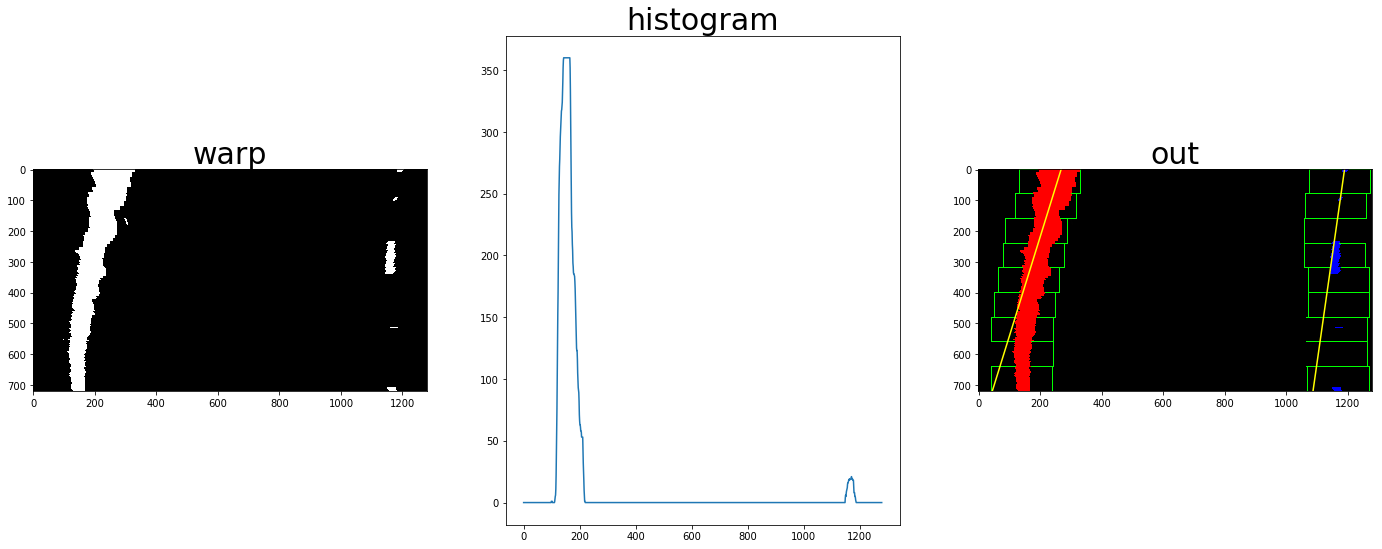

In [33]:
img = mpimg.imread("test_images/c1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
s_binary = hls_thresh(undist, 2, (100, 255))
roi = region_of_interest(s_binary, roi_points)
warped = warp(roi, roi_points)
out = np.dstack((warped, warped, warped)) ** 255
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

midpoint = np.int(histogram.shape[0]/2)
left_base = np.argmax(histogram[:midpoint])
right_base = np.argmax(histogram[midpoint:]) + midpoint

# the number of sliding windows
nwindows = 9
# set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# current positions to be updated for each window
left_current = left_base
right_current = right_base
# set with width of the windows +/- margin
margin = 100
# set minimum number of pixels found to recenter window
minpix = 50
# create empty lists to recerve left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

#  step through the windows one by one
for window in range(nwindows):
    # identify window boundaries in x and y (and right and left)
    win_low = warped.shape[0] - (window + 1) * window_height
    win_high = warped.shape[0]- window * window_height
    win_left_left = left_current - margin
    win_left_right = left_current + margin
    win_right_left = right_current - margin
    win_right_right = right_current + margin
    # draw the windows on the visualization image
    cv2.rectangle(out, (win_left_left, win_low), (win_left_right, win_high), (0, 255, 0), 2)
    cv2.rectangle(out, (win_right_left, win_low), (win_right_right, win_high), (0, 255, 0), 2)
    # identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_left_left) & (nonzerox < win_left_right)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_right_left) & (nonzerox < win_right_right)).nonzero()[0]
    # append these indices to the list
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # if you found > minpix pixels, recenter next window on theri mean position
    if len(good_left_inds) > minpix:
        left_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        right_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)  
right_lane_inds = np.concatenate(right_lane_inds)

# extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
print(leftx, lefty)
print(rightx, righty)

# fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
left_fitx = left_fit[0] * ploty * 2 + left_fit[1] * ploty + left_fit[2] 
right_fitx = right_fit[0] * ploty * 2 + right_fit[1] * ploty + right_fit[2] 

out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('out', fontsize=30)
axs[2].plot(left_fitx, ploty, color='yellow'), axs[2].plot(right_fitx, ploty, color='yellow')